In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

In [3]:
print(bdata.keys())
print(bdata.feature_names)
print(bdata.data.shape)
print(bdata.target.shape)

dict_keys(['data', 'target', 'feature_names', 'DESCR'])
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
(506, 13)
(506,)


---

## Part 1: Descriptive analysis


### 1.1: Histogram of housing prices

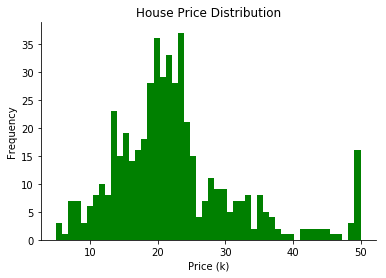

In [5]:
# prepare IPython to work with matplotlib and import the library to something convenient
%matplotlib inline  
import matplotlib.pyplot as plt  
plt.figure()
plt.hist(bdata.target, bins=50, facecolor="green", edgecolor="none")
plt.xlabel('Price (k)') # change xlabel
plt.ylabel('Frequency') # change ylabel
plt.title("House Price Distribution")
axe = plt.axes() # return axes
axe.spines['right'].set_visible(False) # invisible right spine
axe.spines['top'].set_visible(False) # invisible top spine
axe.yaxis.set_ticks_position('left') 
axe.xaxis.set_ticks_position('bottom')

### 1.2: Scatter plot of housing prices and crime

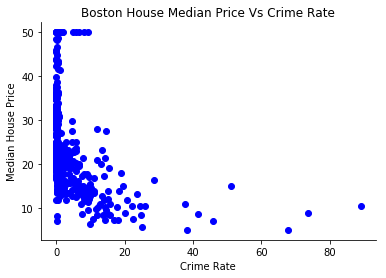

In [6]:
plt.figure()
plt.scatter(x=bdata.data[:, 0], y=bdata.target, color="blue") # scatterplot of crime rate and price
plt.xlabel('Crime Rate') # change xlabel
plt.ylabel('Median House Price') # change ylabel
plt.title('Boston House Median Price Vs Crime Rate') # change title
ax1 = plt.axes()
ax1.spines['right'].set_visible(False) # invisible right spine
ax1.spines['top'].set_visible(False) # invisible top spine
ax1.yaxis.set_ticks_position('left') 
ax1.xaxis.set_ticks_position('bottom')

### Boxplot of housing price and bounding river

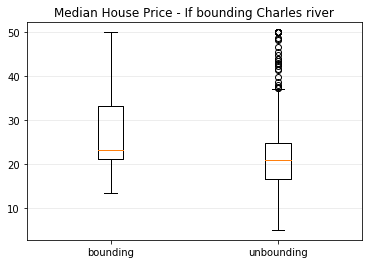

In [8]:
x = bdata.data
rows = x[:, 3]==1 # houses bounding river
Chas = [bdata.target[rows], bdata.target[~rows]] # concatnate houses bounding and unbounding river
fig, ax = plt.subplots()
plt.boxplot(Chas)
plt.title('Median House Price - If bounding Charles river') # change title
xtickNames = plt.setp(ax, xticklabels=['bounding', 'unbounding']) # change xlabel 
plt.setp(xtickNames,  fontsize=10)
# add a horizontal grid 
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
plt.show()

---

## Part 2: Experimental Setup

Design an experiment to predict the median home value for an instance in the data.

### 2.1 Root Mean Squared Error 

In [9]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6))
2.16
"""
def compute_rmse(predictions, yvalues):
    diff = np.array(predictions)-np.array(yvalues) # difference between y and predicted y
    rmse = np.sqrt(np.mean(diff**2)) # root mean squared error
    return rmse
print(compute_rmse((2,2,3),(0,2,6)))

2.08166599947


### 2.2 Divide data into training and testing datasets

Randomly select 66% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 34% in a testing dataset (call this "bdata_test")


In [13]:
import copy
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)
rand = np.random.rand(bdata.data.shape[0]) # generate a series of random number
mask = rand>0.33 # mask array
bdata_train.data, bdata_train.target = bdata.data[mask], bdata.target[mask]
bdata_test.data, bdata_test.target = bdata.data[~mask], bdata.target[~mask]
print("Training data size:", bdata_train.data.shape[0])
print("Testing data size:", bdata_test.data.shape[0])

Training data size: 337
Testing data size: 169


### 2.3 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Compute the RMSE on the training set, and the RMSE on the test data set by using the model trained on the training set

In [14]:
def bad_predict(dat):
    predict = np.empty(len(dat))
    predict.fill(np.mean(dat))
    return predict
prediction = bad_predict(bdata_train.target) # prediction of traing data
print(compute_rmse(prediction, bdata_train.target)) # rmse of training data
print(compute_rmse(prediction[:len(bdata_test.target)], bdata_test.target)) # rmse of testing data

9.75846821615
7.94621174162


---

## Part 3: Nearest Neighbors


### 3.1 Nearest Neighbors: Distance function
Create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm](http://en.wikipedia.org/wiki/Norm_(mathematics) distance on Wikipedia).

In [15]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(6,8),2)
7

"""
def distance(x1, x2, L):
    diff = abs(np.array(x1) - np.array(x2))
    dist = (sum(diff**L))**(1/L)
    return dist
print(distance((3,4),(6,8),2))


5.0


### 3.2 Basic Nearest Neighbor algorithm

Implement a basic nearest neighbor algorithm from scratch. The simple model will use two input features (CRIM and RM) and a single output (MEDV).  

Use training data (bdata_train) to "fit" the model, although with Nearest Neighbors there is no real training, you just need to keep the training data in memory. For each instance in the testing data (bdata_test), the median home value will be predicted by comparing the test instance to every instance in the training set, and return the MEDV value of the closest training instance.  

In [19]:
"""
Function
-----------
nneighbor

Given a testing dataset, a training dataset, a value for L and a value for K, find K closest instances in the training
dataset for each instance in the testing dataset based on L-norm distance. Take the average target values of the
K closest instance in the testing dataset and to predict the target value of the instance in the testing dataset. 

Parameters
----------
test_dat, test_dat : a dictionary containing a 2-dimension array of data as the input features and a 1-dimension
array of data as the output value

L: int
    Value of L to use in computing distances

K: int
    find K closest instance in the training dataset
    
Returns
-------
rmse : float
    The root mean squared error.

"""
import time
def nneighbor(test_dat, train_dat, L=2, K=1):
    start_time = time.time()
    predict = []
    for test_index in range(len(test_dat.data)):
        dist = {}
        for train_index in range(len(train_dat.data)):            
            dist[train_index] = distance(test_dat.data[test_index], train_dat.data[train_index], L)
        min_dist = sorted(dist, key=dist.get)[:K]        
        predict.append(np.mean(train_dat.target[min_dist]))
        
    rmse = compute_rmse(test_dat.target, predict)
    print("Time taken: " + str(round(time.time() - start_time,2)) + " seconds")
    return rmse

test_dat = copy.deepcopy(bdata_test)
test_dat.data = test_dat.data[:, [0, 5]] # take only CRIM and RM as input features
train_dat = copy.deepcopy(bdata_train)
train_dat.data = train_dat.data[:, [0, 5]]
print("RMSE: ", nneighbor(test_dat, train_dat))


Time taken: 0.43 seconds
RMSE:  7.07750415675


### 3.3 Results and Normalization
Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations.

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

In [20]:
"""
Function
-----------
normalize

Given a numerical array, calculate the normalized array by substracting mean and dividing by the
standard deviation.

Parameters
----------
raw_data: numerical array
    array of numerical values corresponding to a feature of dataset 
    
Returns
-------
norm : float
    normalized array
"""
def normalize(raw_data):
    mean = np.mean(raw_data)
    sd = np.std(raw_data)
    norm = (raw_data - mean)/sd
    return norm

for i in range(train_dat.data.shape[1]):
    train_dat.data[:,i] = normalize(train_dat.data[:,i]) # normalize all features in training set
for i in range(test_dat.data.shape[1]):
    test_dat.data[:,i] = normalize(test_dat.data[:,i]) # normalize all features in testing set

nneighbor(test_dat, train_dat, 2) # calculate rmse based on normalized features


Time taken: 0.44 seconds


7.2231752266596434

With input features being normalized, the test RMSE becomes slightly greater. Normalization changes the distance between the instances of testing dataset and training dataset, which leads to the change of prediction of target.

### 3.4 Optimization

Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L. 


In [82]:
# use features INDUSand NOX
test_dat = copy.deepcopy(bdata_test)
test_dat.data = test_dat.data[:, [2, 4]]
train_dat = copy.deepcopy(bdata_train)
train_dat.data = train_dat.data[:, [2, 4]]
print("INDUX and NOX, L=2:")
print("RMSE:",nneighbor(test_dat, train_dat, 2))
print("\nINDUX and NOX, L=4:")
print("RMSE:", nneighbor(test_dat, train_dat, 4))

# uses features CRIM, INDUS, NOX, RM, TAX, PTRATIO
test_dat = copy.deepcopy(bdata_test)
test_dat.data = test_dat.data[:, [0,2,4,5,9,10]]
train_dat = copy.deepcopy(bdata_train)
train_dat.data = train_dat.data[:, [0,2,4,5,9,10]]
print("\nCRIM, INDUS, NOX, RM, TAX, PTRATIO, L = 2:")
print("RMSE:",nneighbor(test_dat, train_dat, 2))
print("\nCRIM, INDUS, NOX, RM, TAX, PTRATIO, L = 4:")
print("RMSE:",nneighbor(test_dat, train_dat, 4))

# uses features CRIM, ZN, RM, AGE, DIS
test_dat = copy.deepcopy(bdata_test)
test_dat.data = test_dat.data[:, [0,1,5,6,7,9]]
train_dat = copy.deepcopy(bdata_train)
train_dat.data = train_dat.data[:, [0,1,5,6,7,9]]
print("\nCRIM, ZN, RM, AGE, DIS, TAX L = 2:")
print("RMSE:",nneighbor(test_dat, train_dat, 2))

INDUX and NOX, L=2:
Time taken: 0.41 seconds
RMSE: 8.69354994527

INDUX and NOX, L=4:
Time taken: 0.49 seconds
RMSE: 8.79016731468

CRIM, INDUS, NOX, RM, TAX, PTRATIO, L = 2:
Time taken: 0.43 seconds
RMSE: 6.91410957699

CRIM, INDUS, NOX, RM, TAX, PTRATIO, L = 4:
Time taken: 0.53 seconds
RMSE: 6.8808111535

CRIM, ZN, RM, AGE, DIS, TAX L = 2:
Time taken: 0.45 seconds
RMSE: 9.10973859549


The combination of CRIM, INDUS, NOX, RM, TAX and PTRATIO as input features yeilds the lowest RMSE, but changing the value of L didn't make big impact in this case. 

### 3.5 Cross-Validation

Implement a simple k-fold cross-validation algorithm. 
Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide THE dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations.

In [21]:
cv_dat = copy.deepcopy(bdata)
temp = np.insert(cv_dat.data,0, cv_dat.target, axis = 1)
np.random.shuffle(temp) # randomly shuffle the original data copy
cv_dat.data = temp[:,1:]
cv_dat.target = temp[:,0]
step = int(cv_dat.data.shape[0]/10) # split data into k-folds
cv_RMSE = []
for i in range(10):
        train_dat = copy.deepcopy(cv_dat)
        test_dat = copy.deepcopy(cv_dat)
        mask = np.ones(len(cv_dat.data), dtype=bool) # create a mask array
        if (i+1)*step > len(cv_dat.data): # if out of boundary
            break 
        else:
            mask[i*step: (i+1)*step] = False # choose one fold 
        test_dat.data = test_dat.data[~mask] # put the chosen fold into test
        test_dat.target = test_dat.target[~mask]
        train_dat.data = train_dat.data[mask] # put the rest of data into training
        train_dat.target = train_dat.target[mask]
        cv_RMSE.append(nneighbor(test_dat, train_dat, 2))
print("10 folds RMSE:", np.mean(cv_RMSE))

Time taken: 0.22 seconds
Time taken: 0.18 seconds
Time taken: 0.22 seconds
Time taken: 0.18 seconds
Time taken: 0.23 seconds
Time taken: 0.18 seconds
Time taken: 0.22 seconds
Time taken: 0.18 seconds
Time taken: 0.24 seconds
Time taken: 0.18 seconds
10 folds RMSE: 7.07138378497


### 3.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation, report the RMSE for K=3 and the running time of the algorithm.

In [22]:
"""
Function
-----------
knn

Given a dataset, a value for L and a value for K, use K-fold cross-validation to calculate the average
rmse.

Parameters
----------
raw_data: a dataset 
    containing features and target values

L: int
    Value of L to use in computing distances

K: int
    Split data into K folds
    
Returns
-------
rmse : float
    average rmse across the k folds

"""
def knn(raw_dat, L=2, K=1):
    step = int(raw_dat.data.shape[0]/10) 
    cv_RMSE = []
    for i in range(10):
        train_dat = copy.deepcopy(raw_dat)
        test_dat = copy.deepcopy(raw_dat)
        mask = np.ones(len(raw_dat.data), dtype=bool)
        if (i+1)*step > len(cv_dat.data):
            break
        else:
            mask[i*step: (i+1)*step] = False
        train_dat.data = train_dat.data[mask]
        train_dat.target = train_dat.target[mask]
        test_dat.data = test_dat.data[~mask]
        test_dat.target = test_dat.target[~mask]
        cv_RMSE.append(nneighbor(test_dat, train_dat, L, K))
    rmse = np.mean(cv_RMSE)
    return rmse

raw_dat = copy.deepcopy(bdata)
raw_dat.data = raw_dat.data[:,[0,5]]
knn(raw_dat, 2, 3)

Time taken: 0.2 seconds
Time taken: 0.17 seconds
Time taken: 0.2 seconds
Time taken: 0.15 seconds
Time taken: 0.17 seconds
Time taken: 0.16 seconds
Time taken: 0.17 seconds
Time taken: 0.15 seconds
Time taken: 0.17 seconds
Time taken: 0.16 seconds


5.6214819231196049

### 3.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

Time taken: 0.2 seconds
Time taken: 0.17 seconds
Time taken: 0.2 seconds
Time taken: 0.17 seconds
Time taken: 0.2 seconds
Time taken: 0.18 seconds
Time taken: 0.18 seconds
Time taken: 0.17 seconds
Time taken: 0.18 seconds
Time taken: 0.17 seconds
Time taken: 0.22 seconds
Time taken: 0.17 seconds
Time taken: 0.2 seconds
Time taken: 0.19 seconds
Time taken: 0.2 seconds
Time taken: 0.16 seconds
Time taken: 0.17 seconds
Time taken: 0.17 seconds
Time taken: 0.2 seconds
Time taken: 0.16 seconds
Time taken: 0.2 seconds
Time taken: 0.17 seconds
Time taken: 0.2 seconds
Time taken: 0.18 seconds
Time taken: 0.2 seconds
Time taken: 0.18 seconds
Time taken: 0.22 seconds
Time taken: 0.17 seconds
Time taken: 0.2 seconds
Time taken: 0.15 seconds
Time taken: 0.18 seconds
Time taken: 0.2 seconds
Time taken: 0.2 seconds
Time taken: 0.18 seconds
Time taken: 0.23 seconds
Time taken: 0.18 seconds
Time taken: 0.17 seconds
Time taken: 0.25 seconds
Time taken: 0.18 seconds
Time taken: 0.22 seconds
Time taken: 

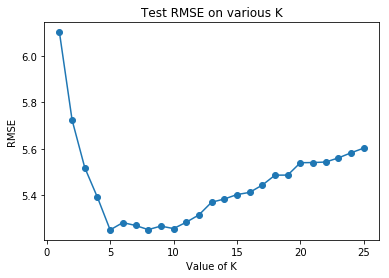

In [23]:
features = [0,1,5,6,7,9] # input features
raw_dat = copy.deepcopy(bdata)
raw_dat.data = raw_dat.data[:, features] # select input features
k_mse = []
for i in range(raw_dat.data.shape[1]): # normalize input features
    raw_dat.data[:, i] = normalize(raw_dat.data[:,i])
for k in range(1,26):
    k_mse.append(knn(raw_dat, 2, k))
print(k_mse)
plt.plot(pd.Series(list(range(1,26))), pd.Series(k_mse),linestyle='-', marker='o')
plt.xlabel('Value of K') # change xlabel
plt.ylabel('RMSE') # change ylabel
plt.title('Test RMSE on various K') # change title

As K increases, the RMSE decreases fast and reaches the lowest point when K is equal to 5. After that, the rmse slowly increases along with K. Therefore, in this case, the best choice of K is 5 and it gives a RMSE around 5.3.   